In [2]:
!pip install dtw-python 

     |████████████████████████████████| 580 kB 7.7 MB/s 


In [3]:
import numpy as np
import pandas as pd 
from random import sample
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
# dynamic time warping
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/m5-forecasting-uncertainty.zip (Unzipped Files)

/content/drive/MyDrive/m5-forecasting-uncertainty.zip (Unzipped Files)


In [6]:
sales = pd.read_csv("sales_train_validation.csv")
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,1,1,2,0,0,2,0,0,0,2,0,1,1,0,0,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,2,1,1,2,4,3,0,0,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


In [9]:
sales.loc[sales.item_id == 'HOBBIES_1_001']\
    .sort_values("id")\
    .head()  

,id,item_id,dept_id,cat_id,store_id,state_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
3049,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,1,2,0,0,1,1,3,0,0,3,1,0,1,1,0,2,0,0,0,0,0,1,0,0,1,0,0,0,1,2,0,4,0,0,2,2
6098,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,0,1,1,6,2,0,2,1,2,1,0,0,0,4,2,1,0,2,0,0,2,1,0,0,0,0,0,2,4,0,1,1,1,0,3,3
9147,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,1,1,3,0,0,3,0,1,2,0,2,1,2,1,1,1,1,0,0,0,0,0,0,0,3,0,0,0,1,0,0,1,0,1,0,1,2,1
12196,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,2


In [8]:
# make time series columns integers for more meaningful plotting (can order numbers)
_cols = list(sales.columns)
sales.columns = pd.Index(_cols[:6] + [int(c.replace("d_","")) for c in _cols[6:]])
del _cols

In [10]:
def series_from_id(_id:str) -> pd.DataFrame:
    """
    Get a daily time series for a single id
    """
    return sales.loc[sales.id == _id]\
    .iloc[:,6:]\
    .T

# Create a global lookup table for fast plotting by department
daily_sales_dept_lookup = sales[["dept_id"] + list(sales.columns[6:])]\
    .melt(id_vars = "dept_id")\
    .groupby("dept_id variable".split())\
    .agg({"value":"sum"})

def series_from_dept(dept:str) -> pd.DataFrame:
    return daily_sales_dept_lookup.loc[dept]

# create a global lookup table for fast plotting by item
daily_sales_item_lookup = sales[["item_id"] + list(sales.columns[6:])]\
    .melt(id_vars = "item_id")\
    .groupby("item_id variable".split())\
    .agg({"value":"sum"})

def series_from_item(item:str) -> pd.DataFrame:
    return daily_sales_item_lookup.loc[item]

"""
Time series for particular items are quite noisy on a daily level. 
Provide the ability to bin sales (for examply - to a weekly bin) for more stable plots
"""
def series_from_id_binned(_id:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an id, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_id(_id).reset_index()
    t["index"] = t.index.map(lambda x: x - (x % bin_every))
    t.columns = pd.Index(["day", "sales"])
    return t.groupby("day")\
        .agg({"sales":"sum"})

def series_from_dept_binned(dept:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for a department, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_dept(dept).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

def series_from_item_binned(item:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an item (across stores), grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_item(item).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

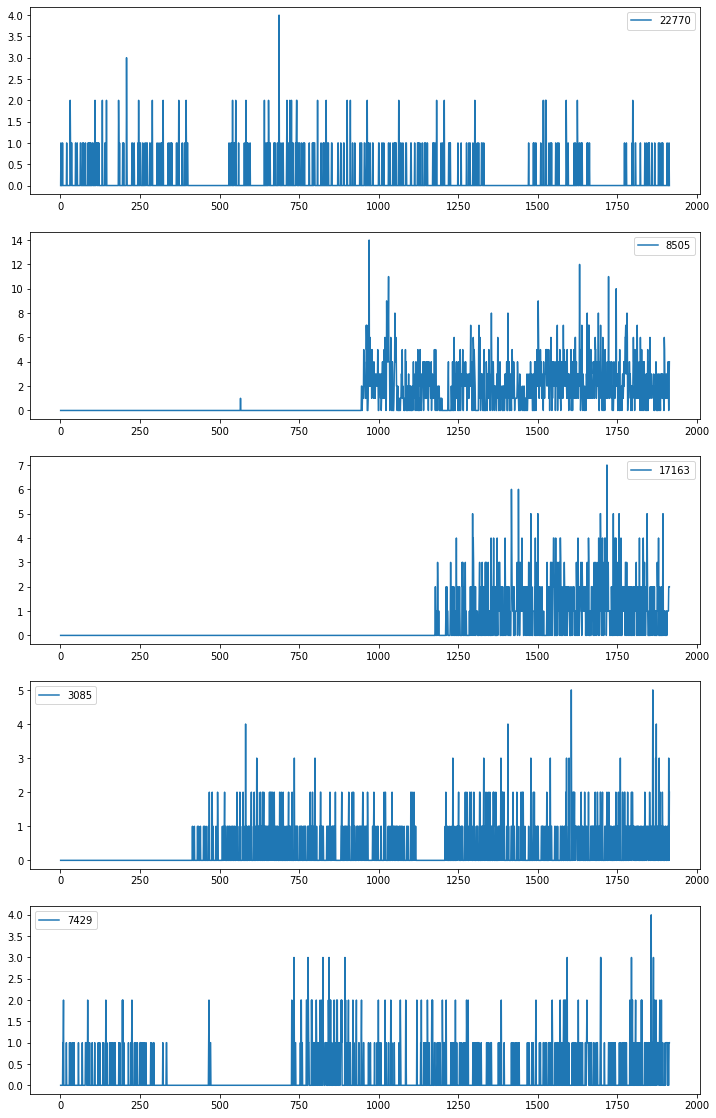

In [11]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
_ids = sales["id"].sample(n = 5, random_state = 1)
for i in range(len(_ids)):
    series_from_id(_ids.iloc[i]).plot(ax = axes[i])
del _ids

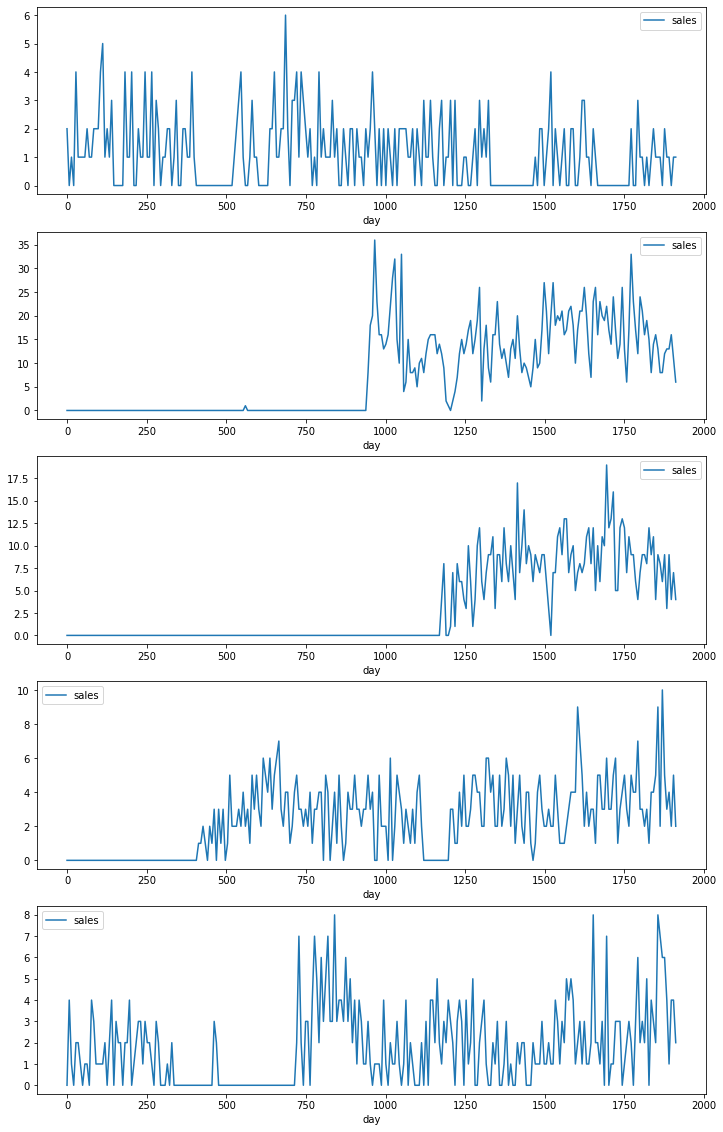

In [12]:
# bin the items by week and plot again
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
_ids = sales["id"].sample(n = 5, random_state = 1)
for i in range(len(_ids)):
    series_from_id_binned(_ids.iloc[i], bin_every = 7).plot(ax = axes[i])

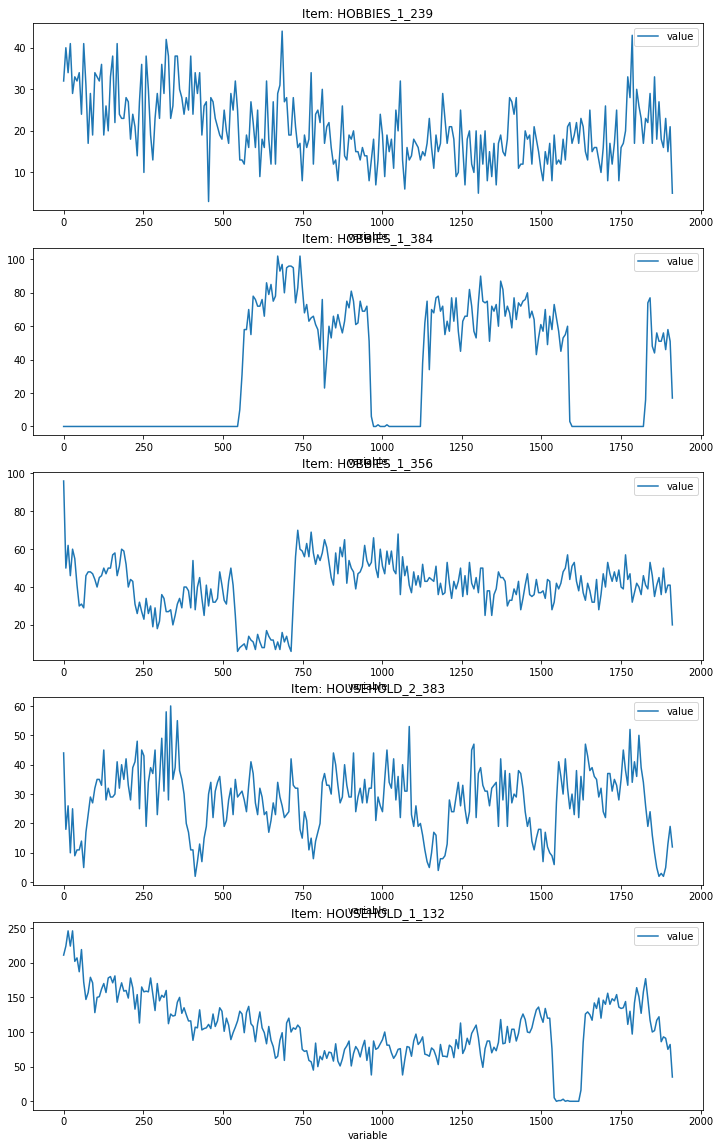

In [13]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(2)
_ids = sample(list(sales["item_id"].unique()), 5)
for i in range(len(_ids)):
    series_from_item_binned(_ids[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Item: %s" % _ids[i])

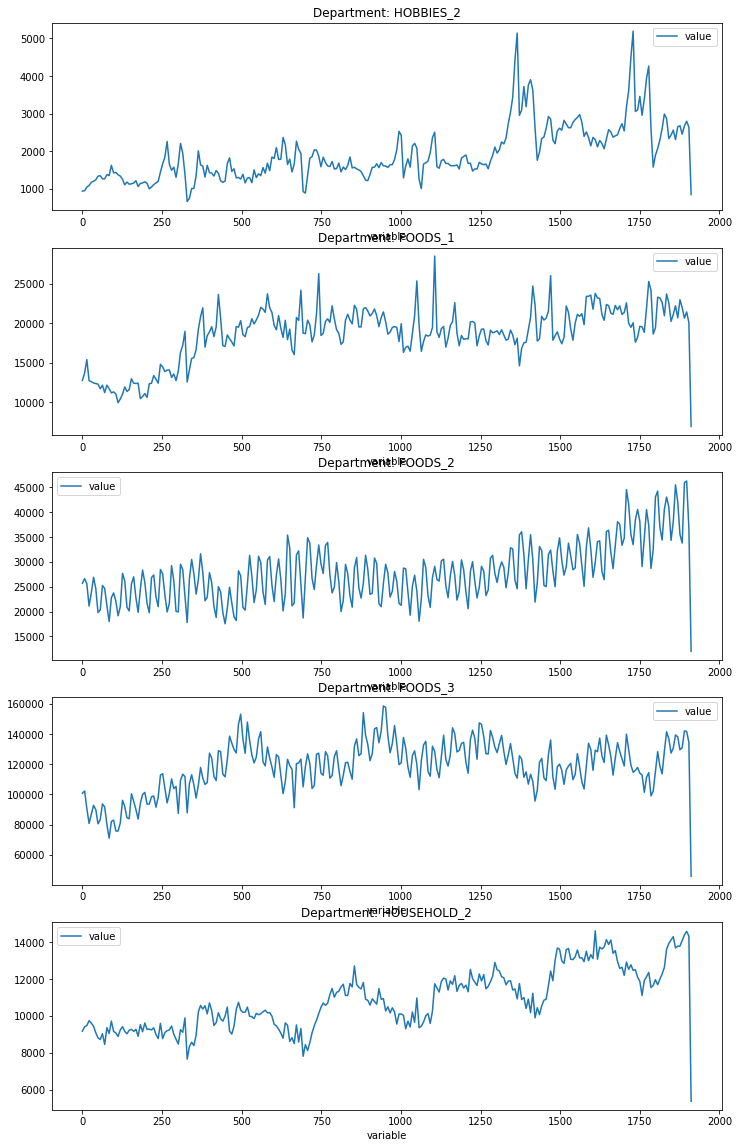

In [14]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(3)
_ids = sample(list(sales["dept_id"].unique()), 5)
for i in range(len(_ids)):
    series_from_dept_binned(_ids[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Department: %s" % _ids[i])

#Clustering 

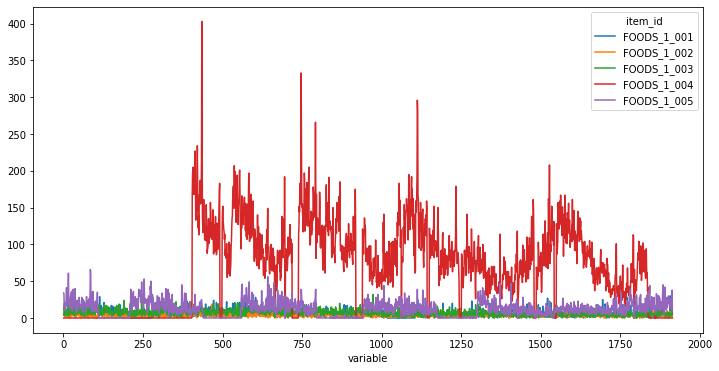

In [15]:
# plotting 10 series, for demonstration
daily_sales_item_lookup.pivot_table(index = "variable", columns = "item_id", values = "value")\
    .iloc[:,:5]\
    .plot(figsize = (12,6))

In [16]:
# Create a lookup table for scaled series
daily_sales_item_lookup_scaled = daily_sales_item_lookup\
    .pivot_table(index = "variable", columns = "item_id", values = "value").copy()
daily_sales_item_lookup_scaled = daily_sales_item_lookup_scaled.div(daily_sales_item_lookup_scaled.mean(axis = 0), axis = 1)
# bin by week
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled.copy().reset_index()
daily_sales_item_lookup_scaled_weekly["variable"] = daily_sales_item_lookup_scaled_weekly.variable.map(lambda x: x - (x%7))
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled_weekly.groupby("variable").mean()

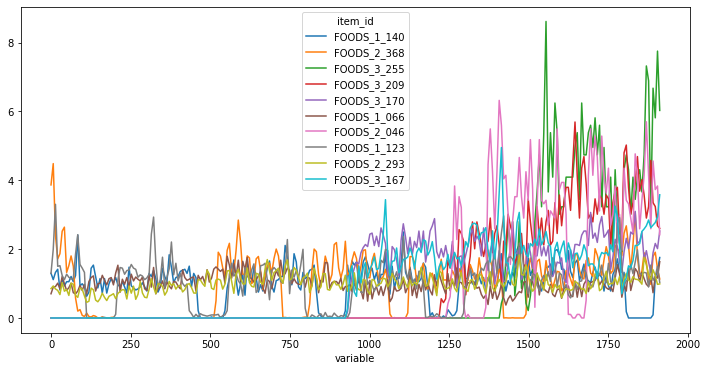

In [17]:
# plot those same series, but this time normalized by the series' means. 
random.seed(1)
daily_sales_item_lookup_scaled_weekly.iloc[:,random.sample(range(1000),10)]\
    .plot(figsize = (12,6))

Hierarchial Clustering

In [18]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

In [19]:
# heirarchical clustering of scales weekly item sales. 
clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(daily_sales_item_lookup_scaled_weekly.T.values)

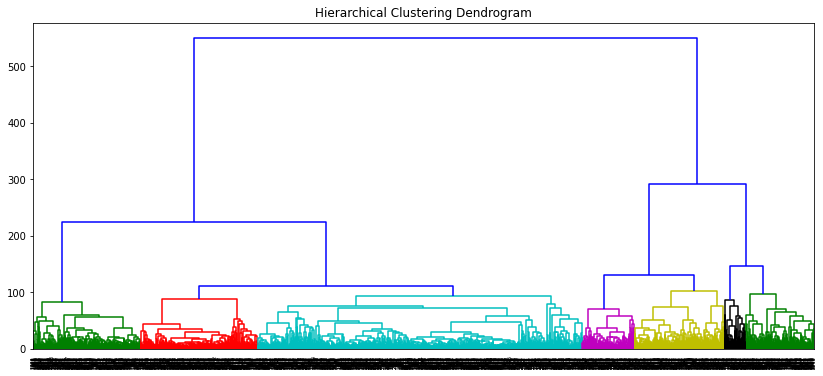

In [20]:
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf, p=5, color_threshold = 110)
plt.show()

In [21]:
# extract clusters from dendogram
clusters = fcluster(Z, 100, criterion='distance')
# create a lookup table for series in a given cluster
daily_sales_item_lookup_scaled_clustered = daily_sales_item_lookup_scaled_weekly.T.reset_index()
daily_sales_item_lookup_scaled_clustered["cluster"] = clusters
daily_sales_item_lookup_scaled_clustered = daily_sales_item_lookup_scaled_clustered.set_index("cluster item_id".split())\
    .sort_index()

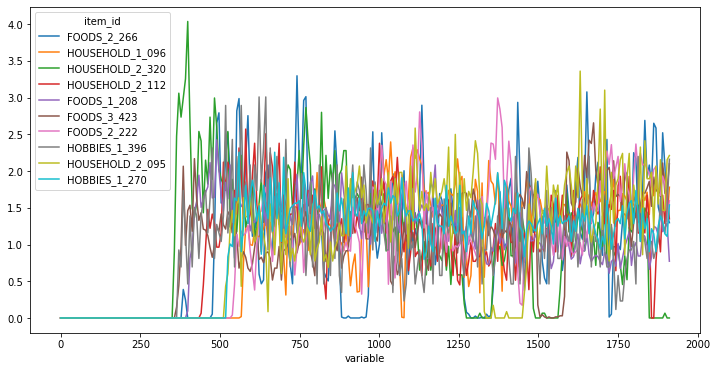

In [22]:
# cluster 1
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[1]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[1].shape[0]), 10)]\
    .plot(figsize = (12,6))

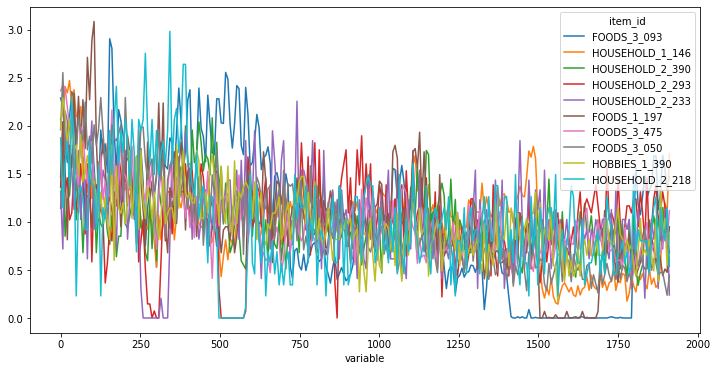

In [23]:
# series 2
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[2]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[2].shape[0]), 10)]\
    .plot(figsize = (12,6))

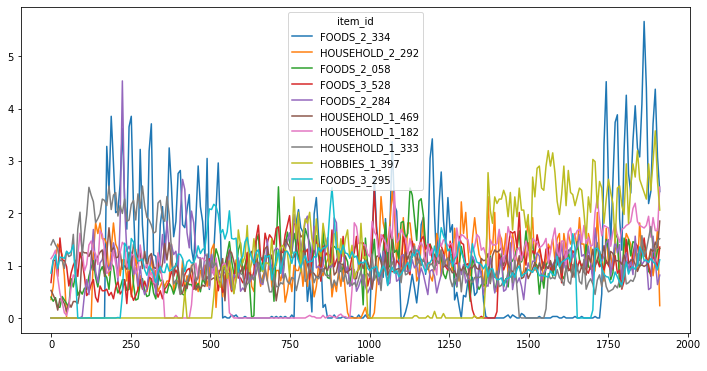

In [24]:
# cluster 3
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[3]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[3].shape[0]), 10)]\
    .plot(figsize = (12,6))

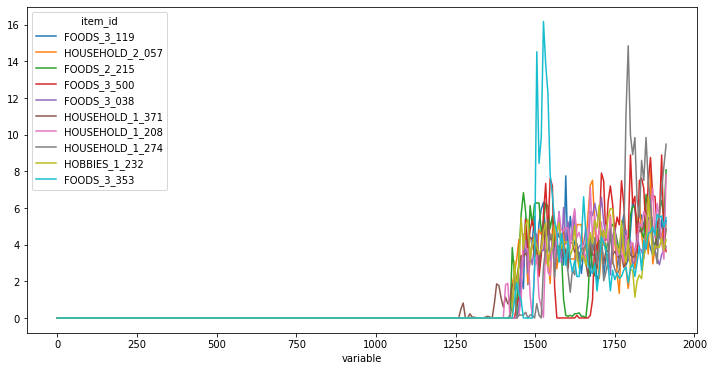

In [25]:
# cluster 7
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[7]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[7].shape[0]), 10)]\
    .plot(figsize = (12,6))

Dynamic Time Warping(DTW)

Text(0.5, 0, 'Days since start')

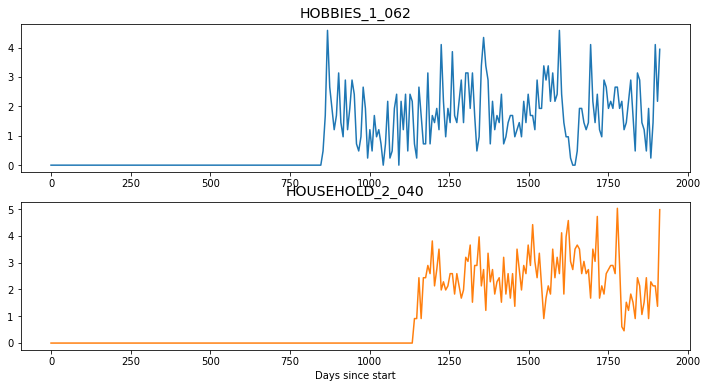

In [26]:
# show two series that look similar but are misaligned, for demonstration purposes
fig, [ax1,ax2] = plt.subplots(nrows = 2, figsize = (12,6))
daily_sales_item_lookup_scaled_weekly["HOBBIES_1_062"].plot(ax = ax1, color = "C0")
daily_sales_item_lookup_scaled_weekly["HOUSEHOLD_2_040"].plot(ax = ax2, color = "C1")
ax1.set_title("HOBBIES_1_062", fontsize= 14)
ax2.set_title("HOUSEHOLD_2_040", fontsize= 14)
ax1.set_xlabel("")
ax2.set_xlabel("Days since start")

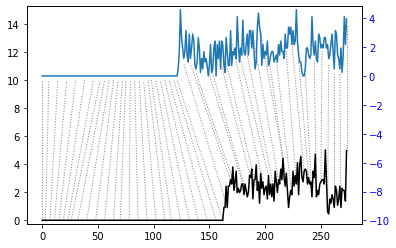

In [27]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(
     daily_sales_item_lookup_scaled_weekly["HOUSEHOLD_2_040"],\
    daily_sales_item_lookup_scaled_weekly["HOBBIES_1_062"],\
    keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(3, "c"))\
    .plot(type="twoway",offset=10)